In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

In [114]:
#import xarray as xr
#dataset = xr.open_dataset('./bou_admin.nc')
#df = ds.to_dataframe()
#df.reset_index()


In [7]:
#comment this entire cell and uncomment the cell above 
df = pd.read_csv('./data.csv',parse_dates = True)
df.rename(columns = {'time_tag':'Time', 'He':'X','Hp':'Y','Hn':'Z'}, inplace = True)

In [8]:
#Splitting data into train and test 
train, test = df.iloc[:int(len(df)*0.7),0:4] , df.iloc[int(len(df)*0.7):,0:4]
print(train)
print(test)

                           Time          X           Y          Z
0     2021-10-06 18:03:00+00:00  11.256454  112.547859  20.824621
1     2021-10-06 18:04:00+00:00  10.683866  112.998840  20.589748
2     2021-10-06 18:05:00+00:00  10.149503  113.312325  20.497410
3     2021-10-06 18:06:00+00:00   9.975222  113.995247  20.810173
4     2021-10-06 18:07:00+00:00   9.836913  114.452515  20.662758
...                         ...        ...         ...        ...
3017  2021-10-08 20:20:00+00:00  12.401943  112.207573  16.442696
3018  2021-10-08 20:21:00+00:00  12.377995  112.232140  16.384068
3019  2021-10-08 20:22:00+00:00  12.352796  112.290039  16.387030
3020  2021-10-08 20:23:00+00:00  12.319927  112.262253  16.364172
3021  2021-10-08 20:24:00+00:00  12.188841  112.229393  16.377003

[3022 rows x 4 columns]
                           Time          X           Y          Z
3022  2021-10-08 20:25:00+00:00  12.210374  112.235603  16.352180
3023  2021-10-08 20:26:00+00:00  12.263288  112.198

In [9]:
#scaling the data
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
#scaler = MinMaxScaler() #Also try QuantileTransformer

scaler = MinMaxScaler()
scaler = scaler.fit(train[['X','Y','Z']])

train[['X','Y','Z']] = scaler.transform(train[['X','Y','Z']])
test[['X','Y','Z']] = scaler.transform(test[['X','Y','Z']])


In [15]:
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size][['X','Y','Z']])
        
    return np.array(x_values), np.array(y_values)

In [34]:

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

seq_size = 30  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


trainX, trainY = to_sequences(train[['X','Y','Z']], train[['X','Y','Z']], seq_size)
trainY = trainY.reshape(len(trainY),1,3)
testX, testY = to_sequences(test[['X','Y','Z']], test[['X','Y','Z']], seq_size)
testY = testY.reshape(len(testY),1,3)

In [35]:
print(trainX , trainX.shape, type(trainX))
print(trainY , trainY.shape, type(trainY))

[[[0.23982256 0.95088715 0.95254592]
  [0.19798549 0.958833   0.93606007]
  [0.15894147 0.96435628 0.92957878]
  ...
  [0.33458542 0.94763117 0.89122103]
  [0.32043447 0.94299494 0.8864523 ]
  [0.31997499 0.93555318 0.87772226]]

 [[0.19798549 0.958833   0.93606007]
  [0.15894147 0.96435628 0.92957878]
  [0.14620736 0.9763887  0.9515318 ]
  ...
  [0.32043447 0.94299494 0.8864523 ]
  [0.31997499 0.93555318 0.87772226]
  [0.35173122 0.94022329 0.88492703]]

 [[0.15894147 0.96435628 0.92957878]
  [0.14620736 0.9763887  0.9515318 ]
  [0.13610164 0.98444531 0.94118465]
  ...
  [0.31997499 0.93555318 0.87772226]
  [0.35173122 0.94022329 0.88492703]
  [0.37133232 0.94205062 0.88080627]]

 ...

 [[0.31324444 0.93223926 0.63991181]
  [0.31366504 0.93335121 0.63573054]
  [0.31511323 0.9345028  0.63037784]
  ...
  [0.31863306 0.94554453 0.64342972]
  [0.32351942 0.94489164 0.64497614]
  [0.32176957 0.94532448 0.64086101]]

 [[0.31366504 0.93335121 0.63573054]
  [0.31511323 0.9345028  0.63037784]


In [28]:

# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
# seq_size = trainX.shape[1]

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(30))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

#Try another model
# model = Sequential()
# model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(rate=0.2))

# model.add(RepeatVector(trainX.shape[1]))

# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(trainX.shape[2])))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 30, 128)           67584     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 30, 64)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 128)           98816     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 3)             387       
Total params: 249,219
Trainable params: 249,219
Non-trainable params: 0
________________________________________________

In [33]:

# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
85/85 [==============================] - 19s 168ms/step - loss: 0.0491 - val_loss: 0.0132
Epoch 2/10
85/85 [==============================] - 13s 154ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 3/10
85/85 [==============================] - 13s 156ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 4/10
85/85 [==============================] - 13s 158ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 5/10
85/85 [==============================] - 16s 184ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 6/10
85/85 [==============================] - 16s 189ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 7/10
85/85 [==============================] - 13s 159ms/step - loss: 8.9830e-04 - val_loss: 0.0024
Epoch 8/10
85/85 [==============================] - 13s 155ms/step - loss: 8.0257e-04 - val_loss: 0.0081
Epoch 9/10
85/85 [==============================] - 13s 156ms/step - loss: 0.0012 - val_loss: 9.8622e-04
Epoch 10/10
85/85 [==============================] - 13s 157ms/step - loss: 6.9

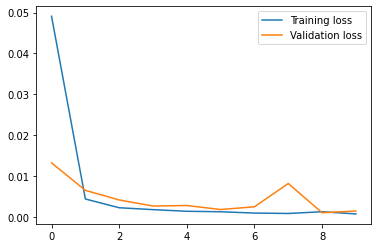

In [36]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


(array([[ 14., 179., 377., 458., 401., 316., 270., 273., 156.,  84.,  77.,
          72.,  71.,  54.,  48.,  44.,  42.,   8.,   6.,   6.,   3.,   2.,
           4.,   3.,   4.,   3.,   5.,   2.,   3.,   7.],
        [302., 899., 618., 403., 408., 162.,  61.,  51.,  16.,   7.,  13.,
           9.,  14.,  11.,   6.,   5.,   5.,   2.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [269., 650., 679., 484., 355., 200., 101.,  67.,  34.,  30.,  18.,
          10.,  18.,  14.,  14.,   6.,   4.,   5.,   5.,   6.,  10.,   9.,
           4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([0.00205579, 0.00751339, 0.01297099, 0.01842858, 0.02388618,
        0.02934377, 0.03480137, 0.04025896, 0.04571656, 0.05117416,
        0.05663175, 0.06208935, 0.06754694, 0.07300454, 0.07846213,
        0.08391973, 0.08937732, 0.09483492, 0.10029252, 0.10575011,
        0.11120771, 0.1166653 , 0.1221229 , 0.12758049, 0.13303809,
        0.13849569, 0.14395328, 0.

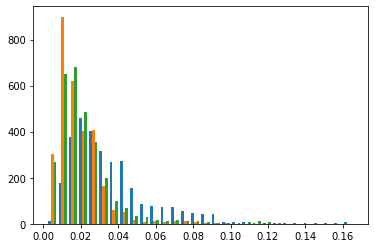

In [37]:
###########################
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)

In [55]:
max_trainMAE = 0.1  #or Define 90% value of max as threshold.
threshold_x = 0.1
threshold_y = 0.08
threshold_z = 0.1

(array([[ 43., 117., 210., 193., 128., 121., 116.,  97.,  50.,  47.,  65.,
          32.,  11.,  21.,   2.,   1.,   2.,   2.,   1.,   2.,   2.,   3.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [149., 270., 306., 189., 138.,  52.,  48.,  13.,  13.,  16.,  20.,
           9.,  22.,   6.,   3.,   2.,   4.,   4.,   2.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 29., 307., 200., 178., 155.,  91.,  84.,  61.,  32.,  22.,  37.,
          15.,   8.,   9.,   2.,   1.,   1.,   1.,   1.,   1.,   2.,   0.,
           6.,   8.,   2.,   2.,   1.,   2.,   2.,   6.]]),
 array([0.00240366, 0.00898589, 0.01556812, 0.02215036, 0.02873259,
        0.03531482, 0.04189705, 0.04847928, 0.05506151, 0.06164375,
        0.06822598, 0.07480821, 0.08139044, 0.08797267, 0.0945549 ,
        0.10113714, 0.10771937, 0.1143016 , 0.12088383, 0.12746606,
        0.1340483 , 0.14063053, 0.14721276, 0.15379499, 0.16037722,
        0.16695945, 0.17354169, 0.

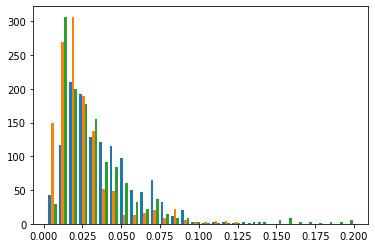

In [63]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)


In [64]:
predictions = []
for seq in testPredict:
    predictions.append(seq[-1])
predictions = np.array(predictions)

In [68]:
predictions = scaler.inverse_transform(predictions)
test[['X','Y','Z']] = scaler.inverse_transform(test[['X','Y','Z']])

In [90]:

#Convert pandas dataframe to numpy array

result_x = pd.DataFrame(test[seq_size:][['Time','X']])
result_x['Predicted'] = predictions[:,0]
result_x['Anomalous'] = testMAE[:,0] >= threshold_x 


result_y = pd.DataFrame(test[seq_size:][['Time','Y']])
result_y['Predicted'] = predictions[:,1]
result_y['Anomalous'] = testMAE[:,0] >= threshold_x

result_z = pd.DataFrame(test[seq_size:][['Time','Z']])
result_z['Predicted'] = predictions[:,2]
result_z['Anomalous'] = testMAE[:,0] >= threshold_z 



<AxesSubplot:xlabel='Time', ylabel='X'>

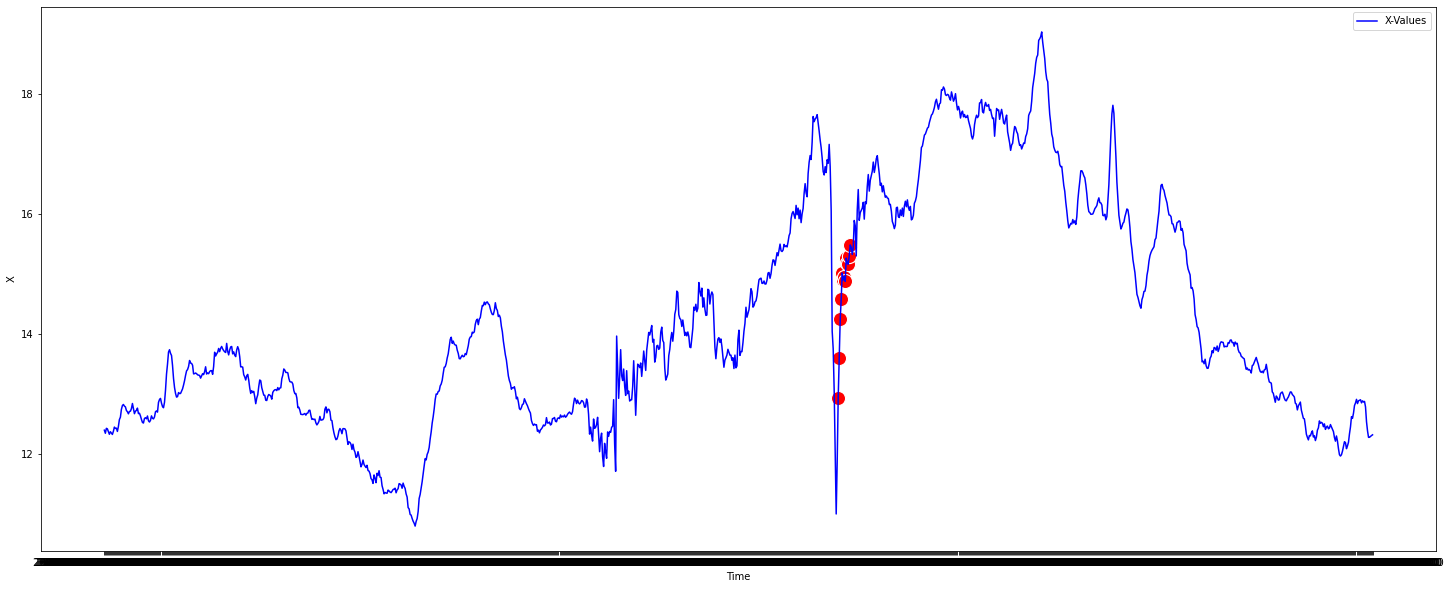

In [97]:
#Plot testMAE vs max_trainMAE
anomalies_x = result_x.loc[result_x['Anomalous'] == True]

#Plot anomalies
plt.figure(figsize=(25, 10))
plt.plot(result_x['Time'],result_x['X'],color='blue',label='X-Values')
sns.scatterplot(x=anomalies_x['Time'], y=anomalies_x['X'], color='r',s=200)


<AxesSubplot:xlabel='Time', ylabel='Y'>

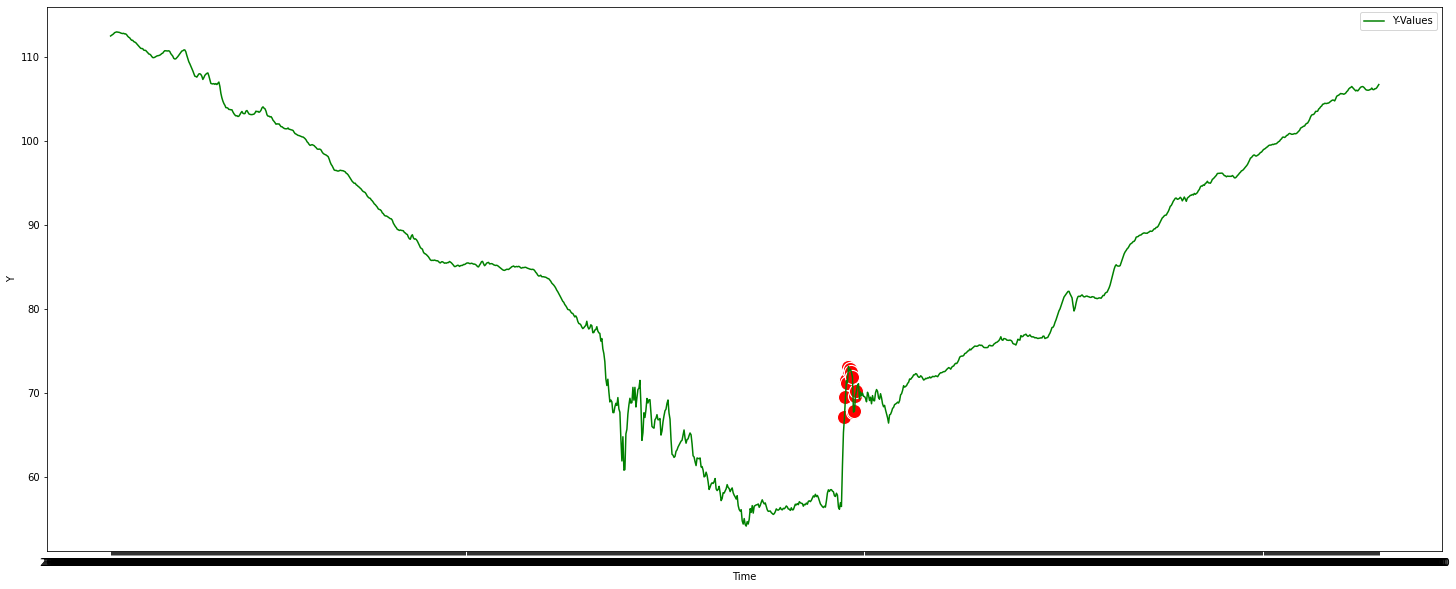

In [95]:
#getting the anomalous Y points
anomalies_y = result_y.loc[result_y['Anomalous'] == True]

#plotting Y values
plt.figure(figsize=(25, 10))
plt.plot(result_y['Time'],result_y['Y'],color='green',label='Y-Values')
sns.scatterplot(x=anomalies_y['Time'], y=anomalies_y['Y'], color='r',s=200)

<AxesSubplot:xlabel='Time', ylabel='Z'>

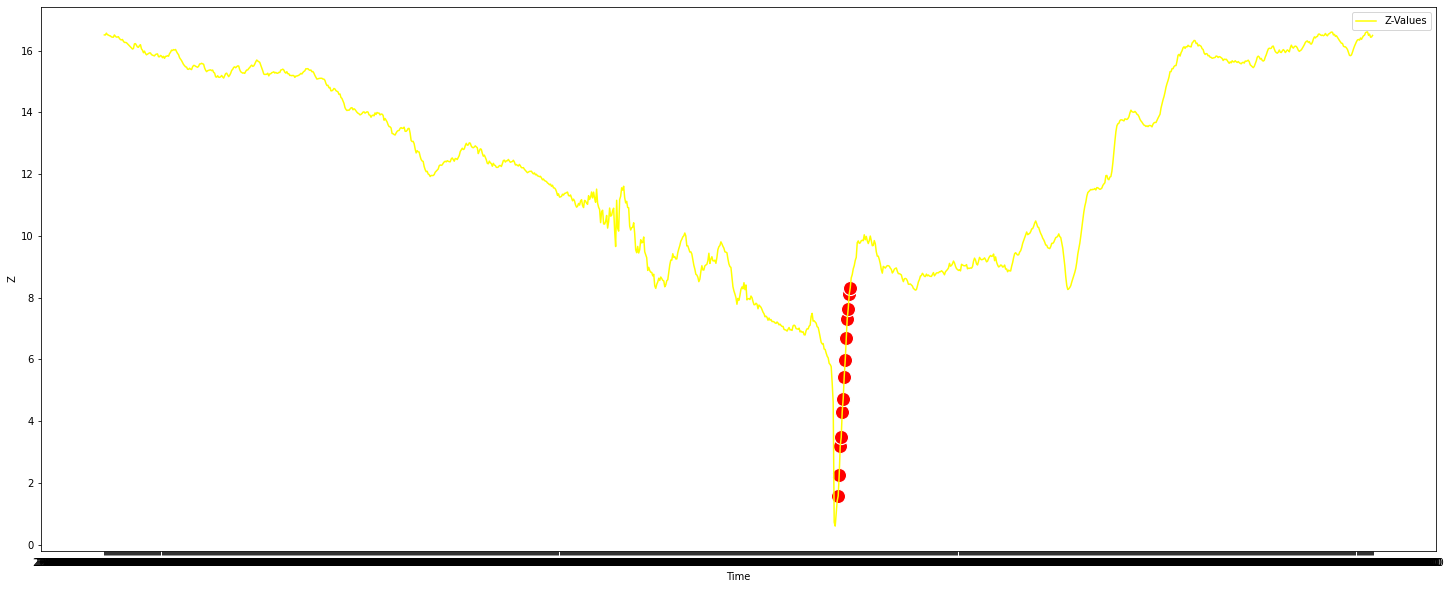

In [96]:
#getting the anomalous Z points
anomalies_z = result_z.loc[result_z['Anomalous'] == True]

#plotting Z values
plt.figure(figsize=(25, 10))
plt.plot(result_z['Time'],result_z['Z'],color='yellow',label='Z-Values')
sns.scatterplot(x=anomalies_z['Time'], y=anomalies_z['Z'], color='r',s=200)